In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import random
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt

/home/nathaniel/.local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
class SVM(object):
    def __init__(self, D, reg_init=0.01, w_init=0.1, b_init=0.1):
        self.a = np.matrix(np.random.rand(D)).T
        self.reg = reg_init
        self.b = b_init
        
    def g_0(self, X, y):
        return self.reg * (self.a.T * self.a) / 2
    
    def g_i(self, X, y):
        return np.maximum(0, 1-(np.multiply(y, X*self.a + self.b)))
        
    def cost(self, X, y):
        N = X.shape[0]
        return ((1/N) * np.sum(self.g_i(X, y))) + self.g_0(X, y)
    
    def single_cost(self, x_k, y_k):
        return y_k * (self.a.T * x_k.T + self.b)
    
    def gradient(self, x_k, y_k):
        if self.single_cost(x_k, y_k) >= 1:
            grad = np.array([self.reg*self.a, 0])
        else:
            grad = np.array([self.reg*self.a - np.multiply(y_k, x_k.T), -y_k])
        return grad
        
    def train(self, X, y, X_test, y_test, alpha=0.1, num_iters=100):
        N = X.shape[0]
        accuracy = np.empty(num_iters // 10)
        for i in range(num_iters):
            idx = random.randint(0, N-1)
            grad = self.gradient(X[idx], y[idx])

            self.a -= alpha * grad[0]
            self.b -= alpha * grad[1]
            if i % 10 == 0:
                accuracy[i//10] = self.score(X_test, y_test)
        return accuracy

    def score(self, X_test, y_test):
        predictions = np.sign(X_test*self.a + self.b)
        return np.sum(1*(predictions == y_test)) / X_test.shape[0]

In [4]:
def class_to_num(x):
    if x == 'M':
        return 1
    else:
        return -1

In [5]:
cols = ['ID', 'class']
cols_append = ['radius', 'texture', 'perimeter', 'area', 'smoothness', 'compactness', 'concavity', 'concave points', 'symmetry', 'fractal dimension']
temp_l = [[i + str(j) for i in cols_append] for j in range(3)]
final_l = [val for sublist in temp_l for val in sublist]
data = pd.read_csv('wdbc.data', names=cols+final_l, index_col='ID')

In [6]:
y = np.matrix(data['class'].apply(class_to_num)).T
data.drop(columns='class', inplace=True)
data_norm = (data - data.mean()) / (data.max() - data.min())
X = np.matrix(data_norm)

In [14]:
scores = np.ones((4,50,10))
reg_list = [1e-3, 1e-2, 1e-1, 1]

for j, reg in enumerate(reg_list):
    for i in range(50):
        svm = SVM(D=X.shape[1], reg_init=reg)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
        scores[j,i,:] = svm.train(X_train, y_train, X_test, y_test)

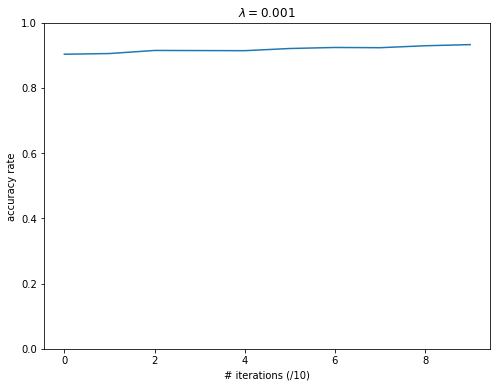

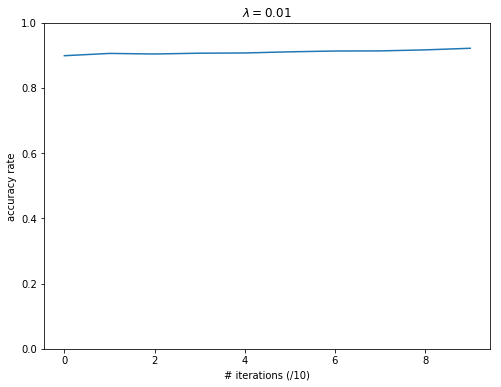

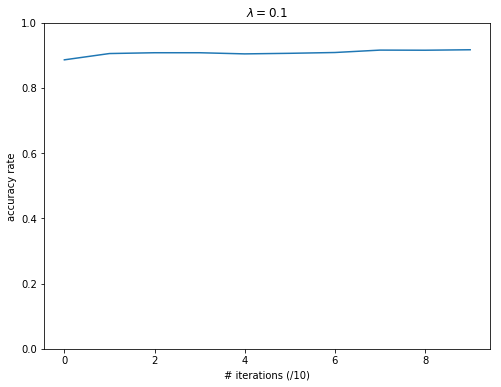

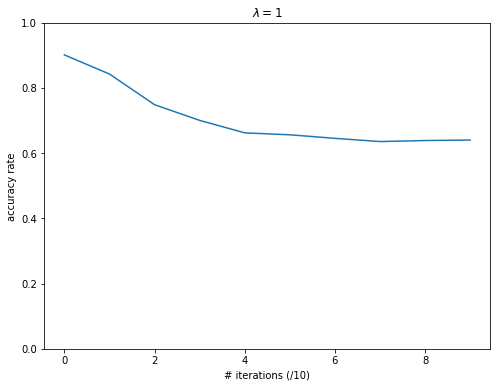

In [15]:
for i, subarr in enumerate(np.mean(scores,axis=1)):
    plt.figure(figsize=(8,6))
    plt.plot(np.arange(10), subarr)
    plt.title('$\lambda=$' + str(reg_list[i]))
    plt.ylim(0,1)
    plt.xlabel('# iterations (/10)')
    plt.ylabel('accuracy rate')
    plt.show()

What I did was kept track of all of the accuracies for every epoch for each of the regularization constants. After running all epochs, for each regularization constant, I averaged the accuracies for every 10 iterations and plotted them above.

It looks as if using the $\lambda=0.001$ regularization constant will give us the best results with our model because, compared with the $\lambda=0.1$ and $\lambda=1$ models, the $\lambda=0.001$ does have significant improvement. The $\lambda=0.01$ and $\lambda=0.001$ models are very close, but the $\lambda=0.001$ model ended up having a slightly higher accuracy. Using the $\lambda=0.001$ model, we will estimate an accuracy for this classifier below.

In [430]:
scores = np.empty(50)
for i in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    svm = SVM(D=X.shape[1], reg_init=0.001)
    svm.train(X_train, y_train, X_test, y_test)
    scores[i] = svm.score(X_test, y_test)
print(np.mean(scores))

0.923157894736842


We see that we can achieve around a 92% accurate classifier using an SVM for this problem.